# Log-likelihood rate tool for exclusion limits and experimental results combinations

In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import poisson, chi2, expon, binom
from scipy.optimize import curve_fit
from scipy.integrate import quad
import pandas as pd
import time
import random as rnd
from tqdm import tqdm
import math 
import sympy 

colors=['darkcyan','indianred','#fb8b24','#392f5a',  'palegoldenrod','olivedrab']

# Establecer un valor de epsilon personalizado
custom_epsilon = 1e-50 # Puedes ajustar este valor según tus necesidades

# Configurar el epsilon personalizado en NumPy
np.finfo(np.float64).eps = custom_epsilon

We define important functions that we will use

In [3]:
def calcular_likelihood(va,mu,nbins):
    likelihood = 1
    ln_likelihood = 0
    for i in range(nbins):
        prob = poisson.pmf(va[i],mu[i])
        ln_likelihood += np.log(prob)
        likelihood = likelihood*prob
    return(likelihood, ln_likelihood)

In [4]:
def exponencial(x,mu):
    return mu*np.exp(-mu*x)

In [5]:
#generates background
def bkg_simul(N,emin,emax):
    bkg = np.array([])
    for j in range(0,N):
        f = rnd.randint(emin,emax)
        bkg=np.append(bkg,f)
    return bkg

#and signal
def signal_expo_simul(M,lamb,emax):
    signal = np.array([])
    count = 0
    while count<M:
        s = np.random.exponential(1/lamb)
        if s<emax:
            count += 1
            signal = np.append(signal,s)
    return signal

In [10]:
def log_q(mu_f,mu_syf,n):
    log_q = 0
    for i in range(len(n)):
        log_q = log_q + (mu_syf[i] - mu_f[i] + n[i]*np.log(mu_f[i]/mu_syf[i]))
    return log_q

1. Generando el fondo: Simular N=10000 realizaciones de una variable aleatoria
con distribución uniforme discreta entre 0 y emax=80, que represente el número de
electrones de N eventos medidos. Hacer un histograma normalizado con un número
de bines nbins a determinar por el usuario. Iniciar con nbins=20.

In [6]:
N = 10000
nbins=20
emin=0
emax=80

Genero fondo

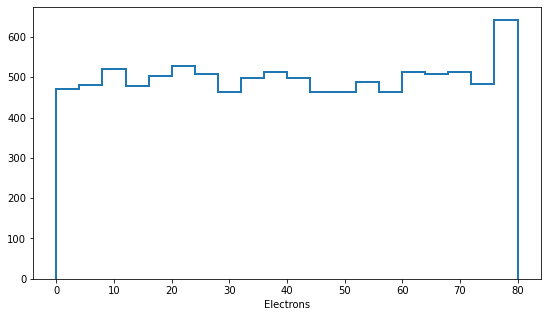

Likelihood L(x_bkg | H0): 6.978061349270308e-48 LogLikelihood: -108.58131332917537


In [7]:
bkg = bkg_simul(N, emin, emax)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
histogram = plt.hist(bkg, nbins, histtype="step", linewidth=2)
plt.xlabel("Electrons")
plt.show()

# To calculate the likelihood for the H0: data (fondo) is comming from H0 (bkg)
prob_bkg = 1/(emax-emin)
edges = histogram[1]
val_histo_bkg = histogram[0]
bin_size = edges[1]-edges[0]
mu_histo_bkg= np.repeat(prob_bkg*bin_size*N,nbins)

L_bkg,ln_L_bkg = calcular_likelihood(val_histo_bkg,mu_histo_bkg,nbins)
print('Likelihood L(x_bkg | H0):',L_bkg,'LogLikelihood:',ln_L_bkg)


2. Generando la señal. En primer lugar repetir el punto anterior (no duplicar el
histograma, sino volver a generar N realizaciones de la misma variable aletoria).
Sumar a este histograma m realizaciones de una variable aleatoria con distribución
exponencial de parámetro λ. Tanto m como λ a fijar por el usuario. Iniciar con
m=100 y λ=0.1. No incluir realizaciones mayores a emax.

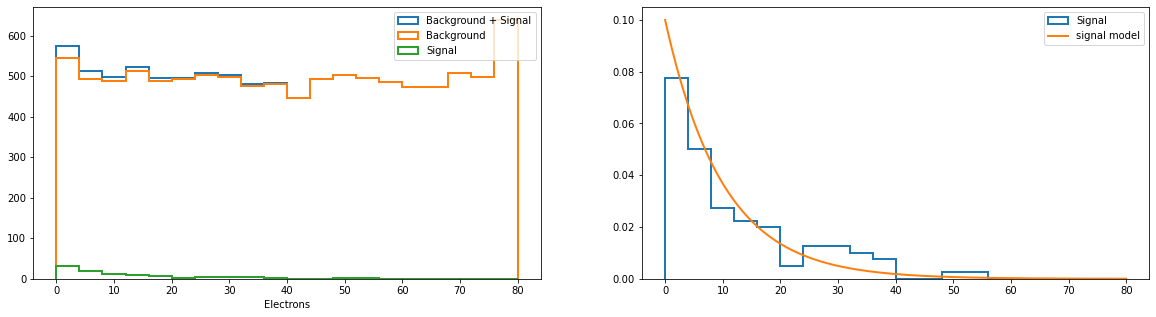

In [8]:
nbins=20
emin=0
emax=80
N=10000
M=100
lamb=0.1

bkg = bkg_simul(N,emin,emax)
signal = signal_expo_simul(M, lamb, emax)
total = np.concatenate((bkg,signal))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
histogram_total = plt.hist(total, nbins, histtype="step", linewidth=2, label='Background + Signal')
plt.xlabel("Electrons")
histogram = plt.hist(bkg, nbins, histtype="step", linewidth=2, label='Background')
plt.xlabel("Electrons")
plt.hist(signal, bins=np.arange(emin, emax+ bin_size, bin_size), histtype="step", linewidth=2, label='Signal' )
plt.legend()

#grafico señal sola
plt.subplot(1, 2, 2)
plt.hist(signal, bins=np.arange(emin, emax+ bin_size, bin_size),density=True, histtype="step", linewidth=2, label='Signal' )
xp=np.linspace(emin,emax,1000)
plt.plot(xp,exponencial(xp,lamb), linewidth=2, label='signal model')
plt.legend()
plt.show()

Calculo $\mu$ de la señal

In [9]:
# To calculate the likelihood for the H1: data (fondo) is comming from H1 (bkg+signal)
# I have to calculate the integral for each binS
signal_integral = np.array([])
err_signal_integral = np.array([])
for bin in range(nbins):
    i,e = quad(exponencial, edges[bin], edges[bin+1], args=(lamb))
    signal_integral = np.append(signal_integral,i)
    err_signal_integral = np.append(err_signal_integral,e)
    #print(bin,edges[bin], edges[bin+1],i,e)
    
mu_histo_signal=N*signal_integral

L_bkgsignal,ln_L_bkgsignal = calcular_likelihood(val_histo_bkg,mu_histo_bkg+mu_histo_signal,nbins)
print('Likelihood L(x_bkg | H1):',L_bkgsignal,'LogLikelihood:',ln_L_bkgsignal)


##  Here I am calculating the mu of the signal because I know the function, but if I do not know, 
## I need to compute the distribution of the signal to evaluate the probability funcion. -- HACER DESPUES! 

Likelihood L(x_bkg | H1): 0.0 LogLikelihood: -inf


C:\Users\Zoe\AppData\Local\Temp\ipykernel_18756\1915559824.py:6: RuntimeWarning: divide by zero encountered in log
  ln_likelihood += np.log(prob)


In [ ]:
def calcular_log_q(N, nbins, emax, emin, M):
    #acaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
    bkg = bkg_simul(N,emin,emax)
    signal = signal_expo_simul(M, lamb, emax)
    bkg_nuevo = bkg_simul(N, lamb, emax) 

    señalyfondo = np.concatenate((bkg_nuevo,signal))

    histograma_bkg = np.histogram(bkg, nbins)
    va_f = histograma_bkg[0] #ni
    borde_bins = histograma_bkg[1]
    anchos = borde_bins[1]-borde_bins[0]

    #calculo verosimilitudes

    prob_f = 1/(emax-emin)
    mu_bkg= np.repeat(prob_f*anchos*N,nbins)
    ln_L_f = calcular_likelihood(va_f,mu_f,nbins)[1]
    #print('Verosimilitud dada H0',ln_L_f)

    areas_integradas = np.array([])
    errores_integracion = np.array([])
    for i in range(nbins):
        lower_limit = borde_bins[i]
        upper_limit = borde_bins[i+1]
        result, error = quad(exponencial, lower_limit, upper_limit, args=(lamb))
        areas_integradas = np.append(areas_integradas, result)
        errores_integracion = np.append(errores_integracion, error)

    histograma_syf = np.histogram(señalyfondo, nbins)
    va_syf = histograma_syf[0]


    mu_s = M*areas_integradas
    ln_L_syf = calcular_likelihood(va_f,mu_s+mu_f,nbins)[1]
    #print('Verosimilitud dada H1',ln_L_syf)

    log_q0 = log_q(mu_f,mu_s+mu_f,va_f)
    log_q1 = log_q(mu_f,mu_s+mu_f,va_syf)
    return(log_q0,log_q1) 